In [1]:

import pygplates
import gprm
from gprm.utils import create_gpml
import numpy as np
#import healpy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Helvetica"

from cmcrameri import cm

In [2]:
#setbasedir for loading reconstruction files
basedir = '/Users/andrew/Library/CloudStorage/GoogleDrive-andrew.merdith@gmail.com/Other computers/My MacBook Pro/GitHub/EarthBytePlateMotionModel-ARCHIVE/Global_1000-0_Model_2017'
rotation_model = pygplates.RotationModel(f'{basedir}/1000_0_rotfile_Merdith_et_al.rot')
polygons = pygplates.FeatureCollection(f'{basedir}/Global_EarthByte_GeeK07_COB_Terranes_ContinentsOnly_MER21.gpml')
topology_features = [f'{basedir}/1000-410-Convergence_Merdith_et_al.gpml',
                     f'{basedir}/1000-410-Divergence_Merdith_et_al.gpml',
                     f'{basedir}/1000-410-Topologies_Merdith_et_al.gpml',
                     f'{basedir}/1000-410-Transforms_Merdith_et_al.gpml',
                     f'{basedir}/250-0_plate_boundaries_Merdith_et_al.gpml',
                     f'{basedir}/410-250_plate_boundaries_Merdith_et_al.gpml',
                     f'{basedir}/TopologyBuildingBlocks_Merdith_et_al.gpml']

In [4]:
#set up some parameters for our analysis
#we need to know what area of the earth each point covers!

#create equal area mesh
latlon_array = []
latlon_mesh = create_gpml.create_gpml_healpix_mesh(32)
for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())
        
#we want to bin data into 5° latitudes
#set up bins and how much area each point covers here

#create bins
bins = np.linspace(-90,90,int(185/5))

#area covered by each point
number_of_points = len(latlon_array)
print( 'number of points', len(latlon_array))

#surface area of the earth
r = 6371
surface_area = 4 * np.pi * r ** 2
print( 'surface area of the earth', surface_area)

area_per_point = surface_area/number_of_points

print( 'area per point', area_per_point)


number of points 12288
surface area of the earth 510064471.90978825
area per point 41509.152987450216


In [5]:
#set time range
times=np.arange(0,1010,10)

#createsan array of lat/lons for our mesh which we use to query the amount of continental mass at each point
latlon_array = []
for i in latlon_mesh:
    for point in i.get_geometry():
        latlon_array.append(point.to_lat_lon())

In [6]:
#we're going to grab subducton zone length as well as continental area
#(if you have convergence rate you could get sub area per lat)

#final results
subduction_latitude_length = []
continental_latitude_area = []

for time in times:
    print(time)
    #create empty lists and arrays for storing temperorary (within a timestep) results
    tmp_sub_lat_length = np.zeros(len(bins)-1,)
    tmp_lat_points = []
    
    #reconstruct and resolve continents and plate boundaries
    reconstructed_features = []
    resolved_topologies = []
    shared_boundary_sections = []

    pygplates.reconstruct(polygons, rotation_model, reconstructed_features, int(time))
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, int(time), shared_boundary_sections)

    #we have to loop through the topologies
    for shared_boundary_section in shared_boundary_sections:
        #we only want subduction zones
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            #and just the segments that contribute to the topologies
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                #tessellate them to n radians so we can fit them to latitude bins
                tessellated_shared_sub_segment_polyline = (
                    shared_sub_segment.get_resolved_geometry().to_tessellated(np.radians(1)))
                
                #we want the midpoints of the segments, to see what latitude they sit in
                #and also the lengths of the arcs so we know how much is there
                tmp_arc_lat_midpoints = []
                tmp_arc_lengths = []
                
                #loop through arcs
                for arc in tessellated_shared_sub_segment_polyline.get_segments():
                    if not arc.is_zero_length():
                        tmp_arc_lengths.append(arc.get_arc_length())
                        tmp_arc_lat_midpoints.append(arc.get_arc_point(0.5).to_lat_lon_array()[:,0])
                        #we just use the mean tessellation length for ease and quickness
                        #this makes it an estimate and not an exact measure (but pretty close)
                        tessellation_length_kms = np.mean(tmp_arc_lengths) * pygplates.Earth.mean_radius_in_kms
                        #get a histogram of the data
                        tmp_sub_data = np.histogram(tmp_arc_lat_midpoints, bins)        
                        tmp_sub_length = tmp_sub_data[0] * tessellation_length_kms
                tmp_sub_lat_length += tmp_sub_length
                
    subduction_latitude_length.append(tmp_sub_lat_length)
    
    #now for continental mass, simpler code but takes longer to run (cos there's a point in polygon test)
    #we loop through our meshgrid and if a node is in a polygon we store the latitude value of that node
    #then we can make a histogram again
    for poly in reconstructed_features:
        poly_geom = poly.get_reconstructed_geometry()
        for i in latlon_array:
            if poly_geom.is_point_in_polygon(i):
                tmp_lat_points.append(i[0])
    tmp_cont_data = np.histogram(tmp_lat_points, bins)
    tmp_cont_area = tmp_cont_data[0] * area_per_point
    continental_latitude_area.append(tmp_cont_area)  
    
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [7]:
#turn into an array so we can plot it as a heatmap
continental_latitude_area_array = np.stack(continental_latitude_area, axis=0 )
subduction_latitude_length_array = np.stack(subduction_latitude_length, axis=0 )

#save data as a csv if you want
#np.savetxt('./results/cont_area_vs_lat.csv', 
#           continental_latitude_area_array, 
#           delimiter=',')

/var/folders/yl/520795yd6sn7d29dw7tkzvc80000gn/T/ipykernel_50704/229497315.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


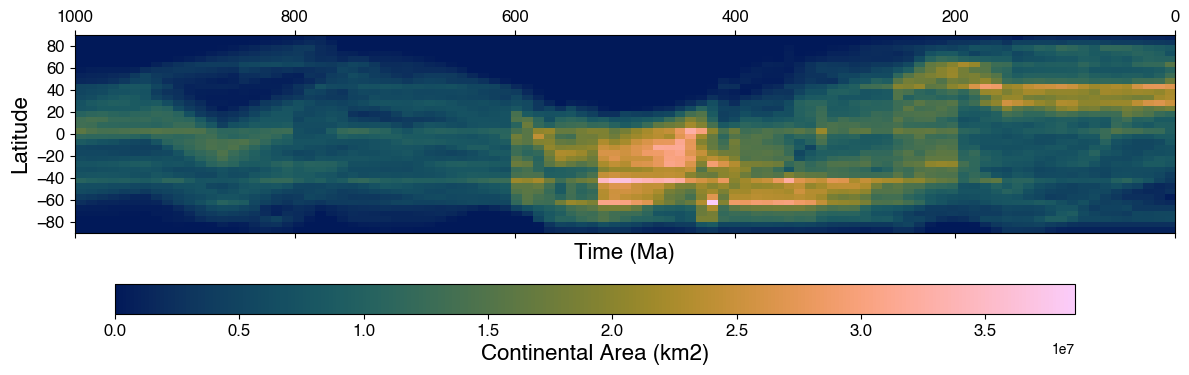

In [21]:
#cm = plt.get_cmap('viridis')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6),facecolor='w', edgecolor='k')

#we have to transpose the array because it's around the wrong way
plot = ax.matshow(continental_latitude_area_array.T, origin='lower', extent=[0,1000,-90,90], cmap=cm.batlow, interpolation='None')
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
cbar.set_label('Continental Area (km2)', fontsize=16)
cbar.ax.tick_params(labelsize=12)
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
savedir = '/Users/andrew/Library/CloudStorage/GoogleDrive-andrew.merdith@gmail.com/Other computers/My MacBook Pro/Proposals/CNRS/figs'
fig.savefig(f'{savedir}/cont_area_vs_latitude.pdf')

/var/folders/yl/520795yd6sn7d29dw7tkzvc80000gn/T/ipykernel_50704/3174906277.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


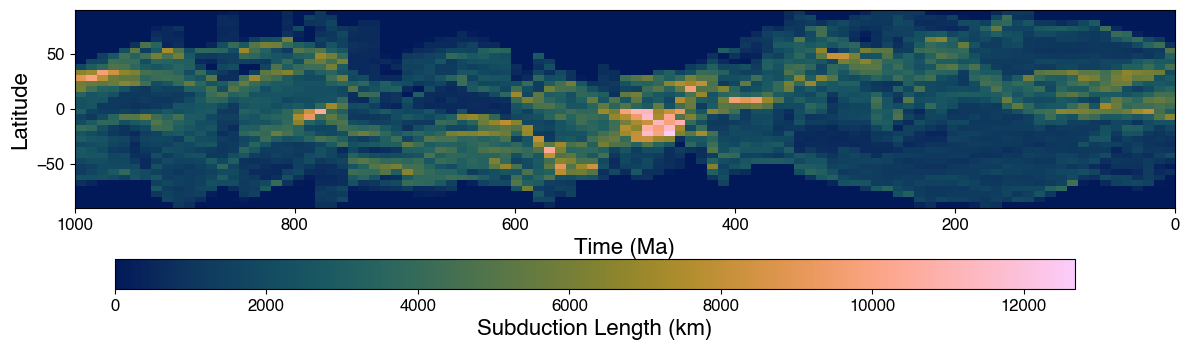

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6),facecolor='w', edgecolor='k')

#we have to transpose the array because it's around the wrong way
plot = ax.imshow(subduction_latitude_length_array.T, origin='lower', extent=[0,1000,-90,90], cmap=cm.batlow, interpolation='None')
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])
cbar = fig.colorbar(plot, cax=cax, orientation='horizontal')
cbar.set_label('Subduction Length (km)', fontsize=16)
cbar.ax.tick_params(labelsize=12)
ax.set_xlim(1000,0)
ax.set_xlabel('Time (Ma)', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout()
savedir = '/Users/andrew/Library/CloudStorage/GoogleDrive-andrew.merdith@gmail.com/Other computers/My MacBook Pro/Proposals/CNRS/figs'
fig.savefig(f'{savedir}/subdction_length_vs_latitude.pdf')